In [2]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Step 1: Install and import libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Check TensorFlow version
print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.18.0


In [4]:
# Step 2: Load the Oxford Pets dataset (images + labels only)
(ds_train, ds_val), ds_info = tfds.load(
    'oxford_iiit_pet',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,  # returns (image, label) pairs
    with_info=True
)

print("Dataset loaded successfully!")
print("Number of training samples:", tf.data.experimental.cardinality(ds_train).numpy())
print("Number of validation samples:", tf.data.experimental.cardinality(ds_val).numpy())


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.GFH719_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.GFH719_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.
Dataset loaded successfully!
Number of training samples: 2944
Number of validation samples: 736


In [5]:
import tensorflow as tf

# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0  # normalize to [0,1]
    return image, label

# Apply preprocessing
ds_train = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_val = ds_val.map(preprocess, num_parallel_calls=AUTOTUNE)

# Shuffle, batch, and prefetch
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2


In [7]:
# Load the Oxford-IIIT Pets dataset
(ds_train, ds_val), ds_info = tfds.load(
    'oxford_iiit_pet',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,  # returns (image, label) pairs
    with_info=True
)


In [8]:
IMG_SIZE = 224
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))   # Resize to 224x224
    image = tf.cast(image, tf.float32) / 255.0              # Normalize to [0, 1]
    return image, label

# Train data pipeline
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Validation data pipeline
ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [9]:
# Load pretrained MobileNetV2 base (exclude top)
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(ds_info.features['label'].num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Train the model
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10
)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - accuracy: 0.2847 - loss: 2.7338 - val_accuracy: 0.8166 - val_loss: 0.6587
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.7442 - loss: 0.8637 - val_accuracy: 0.8791 - val_loss: 0.4564
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.8358 - loss: 0.5693 - val_accuracy: 0.8804 - val_loss: 0.4047
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.8603 - loss: 0.4513 - val_accuracy: 0.8696 - val_loss: 0.3856
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.8897 - loss: 0.3514 - val_accuracy: 0.8668 - val_loss: 0.3612
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.8982 - loss: 0.2990 - val_accuracy: 0.8764 - val_loss: 0.3550
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.9308 - loss: 0.2360 - val_accuracy: 0.8777 - val_loss: 0.3599
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.9252 - loss: 0.2224 - val_accuracy: 

Plot Training Accuracy & Loss

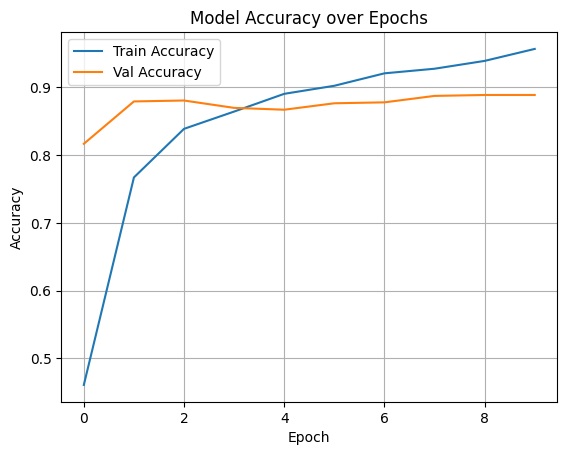

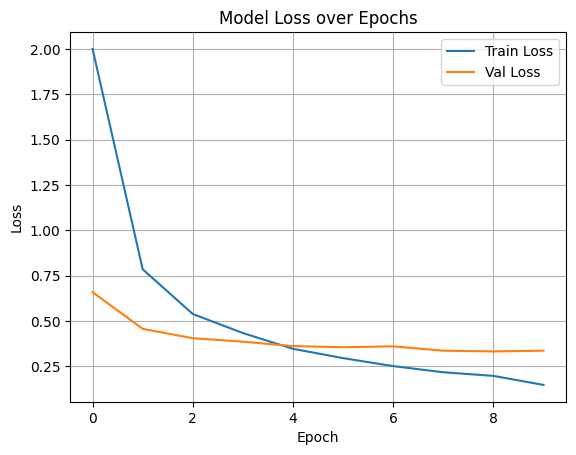

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Evaluate on Validation Set

In [12]:
loss, accuracy = model.evaluate(ds_val)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9072 - loss: 0.2935
Validation Accuracy: 88.86%
Validation Loss: 0.3360


In [15]:
# Saving Model
# Save in native Keras format
model.save('oxford_pet_model.keras')



Make Predictions on New Images

In [17]:
!ls


 drive			  pet_classifier_model.h5   sample_data
 oxford_pet_model.keras  'photo(cd).jpg'


In [19]:
from PIL import Image
import numpy as np

def predict_image(image_path):
    img = Image.open(image_path).resize((224, 224))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img)
    class_idx = np.argmax(prediction)
    class_name = ds_info.features['label'].int2str(class_idx)
    return class_name

# Example: Pass your image path here
print(predict_image('/content/photo(cd).jpg'))



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
great_pyrenees


In [20]:
dog_breeds = [
    'affenpinscher', 'afghan_hound', 'airedale', 'akita', 'appenzeller',
    'australian_terrier', 'basenji', 'beagle', 'blenheim_spaniel',
    'bloodhound', 'border_terrier', 'borzoi', 'boston_bull',
    'boxer', 'brabancon_griffon', 'briard', 'chihuahua',
    'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly_coated_retriever',
    'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'elkhound', 'entlebucher',
    'eskimo_dog', 'flat_coated_retriever', 'french_bulldog', 'german_shepherd',
    'golden_retriever', 'great_pyrenees', 'great_dane', 'greater_swiss_mountain_dog',
    'groenendael', 'ibizan_hound'
]  # short list, Oxford-IIIT has 25 dogs, 12 cats

def predict_image(image_path):
    img = Image.open(image_path).resize((224, 224))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img)
    class_idx = np.argmax(prediction)
    class_name = ds_info.features['label'].int2str(class_idx)

    # Check if breed is dog or cat
    category = "Dog" if class_name in dog_breeds else "Cat"
    return f"{category} - Breed: {class_name}"

# Example:
print(predict_image('/content/photo(cd).jpg'))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Dog - Breed: great_pyrenees


In [21]:
print(predict_image('/content/photo(cd2).jpg'))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Cat - Breed: Ragdoll


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


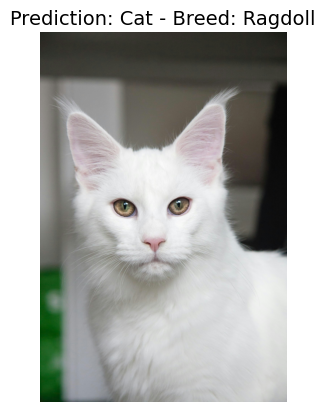

In [22]:
import matplotlib.pyplot as plt

def show_prediction(image_path):
    prediction = predict_image(image_path)
    img = Image.open(image_path)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {prediction}", fontsize=14)
    plt.show()

# Example usage
show_prediction('/content/photo(cd2).jpg')
